In [23]:
from google.colab import files
files.upload()  # Upload the kaggle.json file when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vinaykhera","key":"022b2a057f658406d6d579c1674e2d75"}'}

In [24]:
import os
import zipfile

# Move kaggle.json to the correct location
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Replace this with your dataset name
dataset_name = "kwentar/blur-dataset"  # e.g. lklabc/blur-dataset

# Download the dataset
!kaggle datasets download -d {dataset_name}


Dataset URL: https://www.kaggle.com/datasets/kwentar/blur-dataset
License(s): CC0-1.0
blur-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
# Automatically find the downloaded zip
import glob
zip_files = glob.glob("*.zip")

for zf in zip_files:
    with zipfile.ZipFile(zf, 'r') as zip_ref:
        zip_ref.extractall("blur-dataset")  # Or another directory


In [26]:
# Import libraries (unchanged, but including for completeness)
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from PIL import Image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define custom dataset class (unchanged)
class BlurDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Define enhanced transforms with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Using device: cuda


In [27]:
# Load dataset
base_path = 'blur-dataset'  # Adjusted to match standard dataset path
sharp_images = [os.path.join(base_path, 'sharp', img) for img in os.listdir(os.path.join(base_path, 'sharp'))]

blurred_images = [os.path.join(base_path, 'motion_blurred', img) for img in os.listdir(os.path.join(base_path, 'motion_blurred'))]

# Create labels (0 for sharp, 1 for blurred)
image_paths = sharp_images + blurred_images
labels = [0] * len(sharp_images) + [1] * len(blurred_images)

# Split dataset with validation set
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create datasets
train_dataset = BlurDataset(train_paths, train_labels, transform=train_transform)
val_dataset = BlurDataset(val_paths, val_labels, transform=test_transform)
test_dataset = BlurDataset(test_paths, test_labels, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
# Import libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from PIL import Image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define custom dataset class
class BlurDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
base_path = 'blur-dataset'
sharp_images = [os.path.join(base_path, 'sharp', img) for img in os.listdir(os.path.join(base_path, 'sharp'))]
blurred_images = [os.path.join(base_path, 'motion_blurred', img) for img in os.listdir(os.path.join(base_path, 'motion_blurred'))]

# Create labels (0 for sharp, 1 for blurred)
image_paths = sharp_images + blurred_images
labels = [0] * len(sharp_images) + [1] * len(blurred_images)

# Split dataset with validation set
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create datasets
train_dataset = BlurDataset(train_paths, train_labels, transform=train_transform)
val_dataset = BlurDataset(val_paths, val_labels, transform=test_transform)
test_dataset = BlurDataset(test_paths, test_labels, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Using device: cuda


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 54.3MB/s]


Saved best model with F1 score: 75.38%
Epoch [1/50]
Train Loss: 0.6357, Val Loss: 0.5754, Val Accuracy: 69.52%, Val F1 Score: 75.38%
Epoch [2/50]
Train Loss: 0.5066, Val Loss: 0.5070, Val Accuracy: 68.57%, Val F1 Score: 74.42%
Saved best model with F1 score: 78.40%
Epoch [3/50]
Train Loss: 0.4390, Val Loss: 0.4669, Val Accuracy: 74.29%, Val F1 Score: 78.40%
Saved best model with F1 score: 79.03%
Epoch [4/50]
Train Loss: 0.3962, Val Loss: 0.4460, Val Accuracy: 75.24%, Val F1 Score: 79.03%
Saved best model with F1 score: 80.33%
Epoch [5/50]
Train Loss: 0.3579, Val Loss: 0.4285, Val Accuracy: 77.14%, Val F1 Score: 80.33%
Saved best model with F1 score: 81.60%
Epoch [6/50]
Train Loss: 0.3376, Val Loss: 0.4231, Val Accuracy: 78.10%, Val F1 Score: 81.60%
Epoch [7/50]
Train Loss: 0.3040, Val Loss: 0.4161, Val Accuracy: 78.10%, Val F1 Score: 81.60%
Epoch [8/50]
Train Loss: 0.2937, Val Loss: 0.4135, Val Accuracy: 77.14%, Val F1 Score: 80.95%
Epoch [9/50]
Train Loss: 0.2594, Val Loss: 0.4100, Va

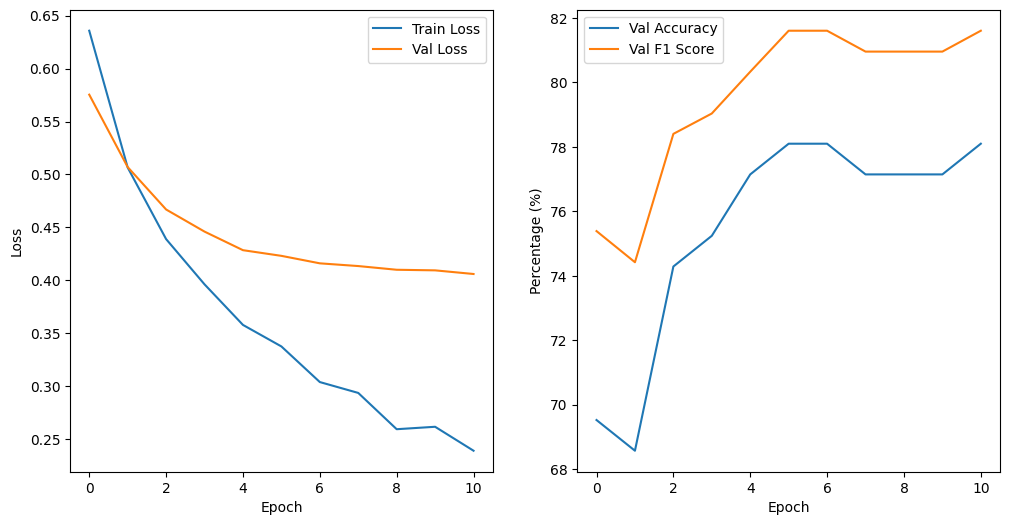

In [32]:
# Initialize Vision Transformer model
model = models.vit_b_16(weights='IMAGENET1K_V1').to(device)  # Load pre-trained ViT
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, 1)  # Modify head for binary classification
).to(device)

# Freeze all layers except the head
for param in model.parameters():
    param.requires_grad = False
for param in model.heads.parameters():
    param.requires_grad = True

# Define loss, optimizer, and scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.heads.parameters(), lr=0.001, weight_decay=0.01)  # Higher LR for fine-tuning
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training function
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    best_f1 = 0.0
    best_model_path = 'best_vit_model.pth'
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                preds = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_f1 = f1_score(all_labels, all_preds) * 100

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        # Save best model based on F1 score
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), best_model_path)
            print(f'Saved best model with F1 score: {best_f1:.2f}%')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

        # Step scheduler
        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val F1 Score: {val_f1:.2f}%')

    # Evaluate on test set with best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    test_f1 = f1_score(all_labels, all_preds) * 100
    print(f'\nFinal Test Results with Best Model:')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1 Score: {test_f1:.2f}%')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.plot(val_f1_scores, label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Percentage (%)')
    plt.legend()
    plt.show()

# Run training
if __name__ == '__main__':
    train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50)